# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация
Дата выдачи: 20.11.2018

Мягкий дедлайн: 6:00MSK 27.11.2018

Жесткий дедлайн: 23:59MSK 29.11.2018

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [19]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ --- алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ --- ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ --- мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ --- "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.11473851370269

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
val_co = np.zeros((X.shape[0],2))  

In [8]:
def compute_biase_variance(regressor, X, y, num_runs=100):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    val_co = np.zeros((X.shape[0],4))
    
    for i in np.arange(0, num_runs):
        data = np.arange(0,X.shape[0])
        boot = resample(data, n_samples=X.shape[0])
        oob = np.array([x for x in data if x not in boot])
        values = regressor.fit(X[boot],y[boot]).predict(X[oob])
        val_co[oob, 0] += values
        val_co[oob,1] += 1
        val_co[oob,2] += values**2
        val_co[oob,3] +=((values - y[oob])**2)
    in_oob = val_co[np.where(val_co[:,1] != 0)]
    biase = ((in_oob[:,0] / in_oob[:,1] - y[np.where(val_co[:,1] != 0)])**2).mean()
    variance = (in_oob[:,2]/in_oob[:,1] - (in_oob[:,0] / in_oob[:,1])**2).mean()
    error = ((in_oob[:,3] / in_oob[:,1])).mean()
    return biase, variance, error
    
in_oob = compute_biase_variance(LinearRegression(), X, y)

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [15]:
print("Decision Tree: ")
print(compute_biase_variance(DecisionTreeRegressor(),X,y))
print("Random forest: ")
print(compute_biase_variance(RandomForestRegressor(),X,y))
print("Linear regression: ")
print(compute_biase_variance(LinearRegression(),X,y))

Decision Tree: 
(10.603054979128505, 12.112223750550882, 22.715278729679365)
Random forest: 
(10.846893208018393, 3.125843245942659, 13.972736453961058)
Linear regression: 
(23.871814562615832, 0.9651279520180792, 24.836942514633893)


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__ вполне согласовывается, в теории у деревье большой разброс, но при этом среднее откланение небольшое, а у линейных моделей наоборот


__3. (1 балл)__
Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ в примере не выполняется уменьшение ошибки в N раз (N - кол-во подвыборок), так как не известно выполняется ли условие некоррелированности ошибок

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__4. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

/home/hacket/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


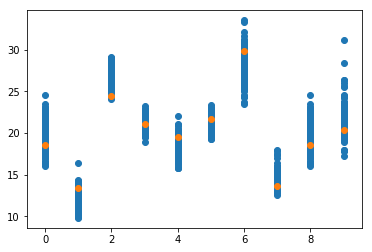

In [72]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", subplot = None):
    """
    plot graphics described above
    """
    np.random.seed(42)
    data = np.arange(0,X.shape[0])     
    test_indexes = resample(data, n_samples=num_test_objects)
    train_indexes = np.array([x for x in data if x not in test_indexes])
    X_test = X[test_indexes]
    y_test = y[test_indexes]
    X_train = X[train_indexes]
    y_train = y[train_indexes]
    
    values = np.zeros((num_runs, X_test.shape[0]))
    
    for i in np.arange(0, num_runs):
        data = np.arange(0,X_train.shape[0])
        boot = resample(data, n_samples=X_train.shape[0])
        #oob = np.array([x for x in data if x not in boot])
        values[i] = regressor.fit(X_train[boot],y_train[boot]).predict(X_test)
    if subplot == None:
        plt.scatter(np.tile(np.arange(0,num_test_objects), [100,1]), values)
        plt.scatter(np.arange(0,num_test_objects), y_test)
        plt.title(title)
    else:
        subplot.scatter(np.tile(np.arange(0,num_test_objects), [100,1]), values)
        subplot.scatter(np.arange(0,num_test_objects), y_test)
        subplot.set_title(title)

plot_predictions(RandomForestRegressor(),X,y)

__5. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

/home/hacket/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


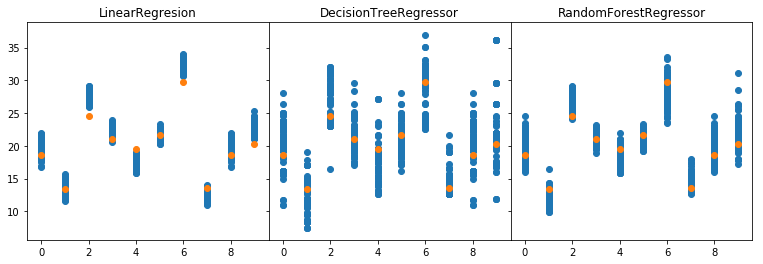

In [73]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize = (13,4))
plot_predictions(LinearRegression(),X,y, subplot=ax[0], title = 'LinearRegresion')
plot_predictions(DecisionTreeRegressor(),X,y, subplot=ax[1],title = 'DecisionTreeRegressor')
plot_predictions(RandomForestRegressor(),X,y, subplot=ax[2], title = 'RandomForestRegressor')
fig.subplots_adjust(wspace = 0, hspace = 0)

__6. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Всё совпадает с теорией, у линейной модели разброз малый, но при этом отклонение большое. У решающего дерева большой разброс, но облако точек покрывает ответ, то есть отклонение не велико. В случае случайного леса отклонение остается небольшим, а разброс уменьшился по сравнению с решающим деревом.

### Изменение bias и variance при изменении гиперпараметров

__7. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

Text(0.5, 0, 'max_features')

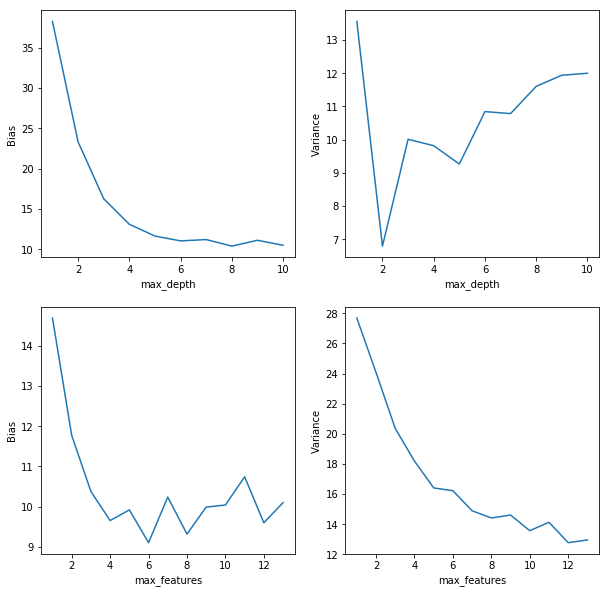

In [87]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
biases, variances = [],[]
depths = np.arange(1, 11)
for depth in depths:
    bias, variance,error = compute_biase_variance(DecisionTreeRegressor(max_depth = depth), X, y)
    biases.append(bias)
    variances.append(variance)
ax[0,0].plot(depths, biases)
ax[0,0].set_ylabel("Bias")
ax[0,0].set_xlabel("max_depth")
ax[0,1].plot(depths, variances)
ax[0,1].set_ylabel('Variance')
ax[0,1].set_xlabel('max_depth')
features = np.arange(1, X.shape[1]+1)

biases, variances = [],[]
for feature in features:
    bias, variance,error = compute_biase_variance(DecisionTreeRegressor(max_features=feature), X, y)
    biases.append(bias)
    variances.append(variance)
ax[1,0].plot(features, biases)
ax[1,0].set_ylabel("Bias")
ax[1,0].set_xlabel("max_features")
ax[1,1].plot(features, variances)
ax[1,1].set_ylabel('Variance')
ax[1,1].set_xlabel('max_features')

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [21]:
fn_estimators = 2**np.arange(1, 10)
biases_rand, variances_rand = [],[]
biases_grad, variances_grad = [], []

for feature in n_estimators:
    bias, variance,error = compute_biase_variance(RandomForestRegressor(n_estimators=feature), X, y)
    biases_rand.append(bias)
    variances_rand.append(variance)
    bias, variance,error = compute_biase_variance(GradientBoostingRegressor(n_estimators=feature), X, y)
    biases_grad.append(bias)
    variances_grad.append(variance)

Text(0.5, 0, 'n_estimators')

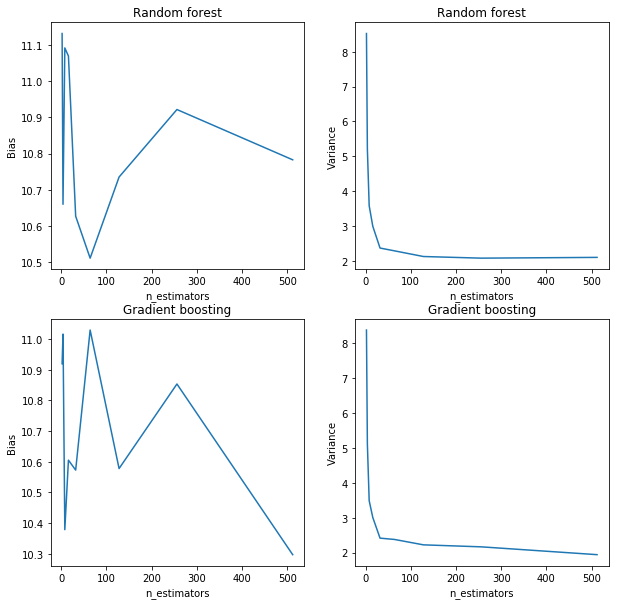

In [24]:
ig, ax = plt.subplots(2,2, figsize = (10,10))

ax[0,0].plot(n_estimators, biases_rand)
ax[0,0].set_title('Random forest')
ax[0,1].set_title('Random forest')
ax[0,0].set_ylabel("Bias")
ax[0,0].set_xlabel("n_estimators")
ax[0,1].plot(n_estimators, variances_rand)
ax[0,1].set_ylabel('Variance')
ax[0,1].set_xlabel('n_estimators')

ax[1,0].set_title('Gradient boosting')
ax[1,1].set_title('Gradient boosting')
ax[1,0].plot(n_estimators, biases)
ax[1,0].set_ylabel("Bias")
ax[1,0].set_xlabel("n_estimators")
ax[1,1].plot(n_estimators, variances)
ax[1,1].set_ylabel('Variance')
ax[1,1].set_xlabel('n_estimators')

__3. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

### Решающее дерево:
Увеличение максимального количества признаков уменьшило и смещение, и разброс, так как мы позволяем дереву выбирать наиболее лучшее на данный момент разбиение.
Увеличение же максимальной глубины уменьшает  смещение, но при этом увеличивает разброс модели, так как дерево начинает переобучаться.
### Gradient boosting и Random forest
Стек моделей не приводит к уменьшению смещения, но как и предсказывает теория уменьшает разброс.